# Asset Analysis for Model Calibration

task: Conduct a summary for the following analysis

In the subsequent analysis, we utilize a suite of Python libraries to aid in data manipulation, statistical analysis, and visualization. The table below offers a brief overview of each library and its primary function:

| Library/Function                  | Description                                                                                                      |
|----------------------------------|------------------------------------------------------------------------------------------------------------------|
| `pandas (pd)`                     | Used for data manipulation and analysis with structures like DataFrames and Series.                               |
| `numpy (np)`                      | Provides support for arrays and mathematical functions for numerical computing.                                   |
| `scipy.signal.detrend`           | Removes linear trends from signals, making non-stationary series stationary.                                      |
| `scipy.stats.norm`               | Provides functions for working with normal (Gaussian) distributions.                                              |
| `statsmodels.tsa.stattools.acf`  | Computes the autocorrelation function to identify patterns in time-series data.                                   |
| `matplotlib.pyplot (plt)`        | A MATLAB-like interface for creating plots and visualizations.                                                   |
| `matplotlib.gridspec.GridSpec`   | Allows for complex visual layouts by defining grid structures for subplots.                                       |
| `functions.Hill_pro`             | Computes the Hill estimators distribution of data up to a given percentile, used for heavy-tail distribution analysis.      |
| `warnings`                       | Suppresses warning messages to ensure clean outputs in notebooks or reports.                                     |


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from scipy.signal import detrend
from scipy.stats import norm
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from functions import Hill_pro
import warnings

# Suppress warnings in all notebook ouputs
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Dataset

## Relationship between Price and Wallets

### Dataset Description: `bitcoin-adresses.xlsx`

- **Source**: The dataset was obtained from [coinmetrics.io](https://coinmetrics.io).
- **Date Range**: This dataset encompasses daily observations from January 3, 2009, to February 19, 2023.
- **Download Date**: The dataset was downloaded on February 19, 2023.
- **Columns**:
  - **BTC Closing Price**: Represents the closing price of Bitcoin on a given day.
  - **BTC Wallet Count**: Denotes the total count of Bitcoin wallets on a specific day.
  - **BTC Active Wallets**: Indicates the number of active Bitcoin wallets on a given day.
- **Observations**: The dataset contains a total of 5,161 daily observations.

The dataset `bitcoin-adresses.xlsx` is imported using the pandas library. The data is read from an Excel file located in the `../data/BTC/`` directory. Once imported:
1. The `Time` column, which represents the date for each observation, is converted into a datetime object using the pd.to_datetime function.
2. This converted `Time` column is then set as the index of the DataFrame for easier time series manipulation.
3. The original `Time` column is dropped from the DataFrame since it's now redundant after setting it as the index.
4. Finally, the imported data's length (in days) is printed out for inspection, and the DataFrame `btcwlt` is displayed.

In [21]:
# Import BTC wallet data from excel-file
btcwlt = pd.read_excel('../data/BTC/bitcoin-adresses.xlsx')
btcwlt.set_index(pd.to_datetime(btcwlt.Time), inplace=True, drop=True)
btcwlt = btcwlt.drop('Time', axis=1)

# Show imported data for inspection
print('Data imported ... containing ' + str(len(btcwlt)) + ' observations (rows)')
print('Start: ' + str(btcwlt.index[0]) + ' | End: ' + str(btcwlt.index[-1]))
print('Columns: ' + str(list(btcwlt.columns)))

Data imported ... containing 5161 observations (rows)
Start: 2009-01-03 00:00:00 | End: 2023-02-19 00:00:00
Columns: ['Close', 'Active', 'Count']


The daily observations from the `btcwlt` DataFrame are grouped into weekly intervals using the pd.Grouper function with a frequency parameter set to `W`, which stands for `Week`. Once the data is grouped by week, the mean value for each week is computed for all columns, resulting in a new DataFrame `wltW` that contains the weekly average values. This transformation condenses the daily observations into a summary of weekly mean values. After the conversion, the length (in weeks) of the newly formed `wltW` DataFrame is printed for inspection, and the DataFrame itself is displayed.

In [53]:
# Group data by week and calculate weekly mean values
gw = btcwlt.groupby(pd.Grouper(freq='W'))
wltW = gw.mean()

# Show calculated weekly data for inspection
print('Weekly data frame created from calculated mean values ... ' + str(len(wltW)) + ' observations (rows)')
print('Start: ' + str(wltW.index[0]) + ' | End: ' + str(wltW.index[-1]))
print('Columns: ' + str(list(wltW.columns)))

Weekly data frame created from calculated mean values ... 738 observations (rows)
Start: 2009-01-04 00:00:00 | End: 2023-02-19 00:00:00
Columns: ['Close', 'Active', 'Count']


In the upcoming code block, we perform several data transformations and calculations on the weekly dataset:

**New Metrics Calculation**:
- `MarketFlow`: Represents the rolling sum of the differences in the 'Count' column over a 4-week window.
- `Wdiff`: Captures the rolling sum of the differences in the 'Count' column over a 1-week window.
- `Adiff`: Calculates the difference between consecutive entries in the 'Active' column.
- `logPrice`: Converts the 'Close' column values into a logarithmic scale by computing their natural logarithm.
- `logDiff`: Derives the detrended value of the 'logPrice' column, effectively removing any linear trend present in the logPrice series.

**Data Cleaning**: 
- Infinite values, both positive and negative, are replaced with NaN (Not a Number) to maintain data consistency.
- Subsequent to this replacement, any rows containing NaN values are dropped.

**Dataset Trimming**: 
- Observations are filtered to a specific timeframe, retaining only the data from January 1, 2012, to January 1, 2023.

The resulting dataset, post these operations, offers a trimmed set of weekly data with the aforementioned calculated columns.


In [51]:
# Narrow down the data set to the desired time period
wltW = wltW[pd.Timestamp('2012-01-01'):pd.Timestamp('2023-01-01')]

# Calculate differences and logarithms
wltW['MarketFlow'] = wltW.Count.diff().rolling(4).sum()
wltW['Wdiff'] = wltW.Count.diff().rolling(1).sum()
wltW['Adiff'] = wltW.Active.diff()
wltW['logPrice'] = np.log(wltW.Close)
wltW = wltW.replace([np.inf, -np.inf], np.nan).dropna()
wltW['logDiff'] = detrend(wltW.logPrice)


# Show trimmed weekly calculations for inspection
print('New columns from diff and log calculations ... ' + str(len(wltW)) + ' observations (rows)')
print('Start: ' + str(wltW.index[0]) + ' | End: ' + str(wltW.index[-1]))
print('Columns: ' + str(list(wltW.columns)))

New columns from diff and log calculations ... 571 observations (rows)
Start: 2012-01-29 00:00:00 | End: 2023-01-01 00:00:00
Columns: ['Close', 'Active', 'Count', 'MarketFlow', 'Wdiff', 'Adiff', 'logPrice', 'logDiff']


In [52]:
wltW

,Close,Active,Count,MarketFlow,Wdiff,Adiff,logPrice,logDiff
Time,,,,,,,,
2012-01-29,5.740201,14450.857143,5.780880e+05,10570.142857,4180.142857,407.285714,1.747494,-1.511293
2012-02-05,5.820235,15418.428571,5.815764e+05,12156.428571,3488.428571,967.571429,1.761341,-1.511842
2012-02-12,5.666855,14879.571429,5.847623e+05,14523.285714,3185.857143,-538.857143,1.734634,-1.552944
2012-02-19,4.494848,16147.000000,5.888103e+05,14902.428571,4048.000000,1267.428571,1.502932,-1.799042
2012-02-26,4.694811,15390.285714,5.946370e+05,16549.000000,5826.714286,-756.714286,1.546458,-1.769911
...,...,...,...,...,...,...,...,...
2022-12-04,16841.448605,945083.714286,4.341716e+07,235297.857143,-127072.428571,-9334.857143,9.731598,-1.675063
2022-12-11,17066.614300,906518.428571,4.332986e+07,23666.714286,-87296.285714,-38565.285714,9.744879,-1.676177
2022-12-18,17182.975949,907436.571429,4.341732e+07,-350002.285714,87465.000000,918.142857,9.751674,-1.683777


In the upcoming code block, we will generate a composite visualization consisting of two line plots that provide insights into the Bitcoin dataset. The resulting visualization will offer a dual perspective: the evolution of Bitcoin's weekly closing prices and the growth in its wallet ecosystem.

**Legend**:
- Legends are integrated into both subplots for clarity. In the lower plot, legends for both the primary and secondary y-axes differentiate the data series.  

**Layout & Configuration**:
- A figure of size 8x7 inches is initialized with a constrained layout to ensure optimal spacing between elements.
- The `GridSpec` function defines a 2x2 grid layout to organize the two line plots.  


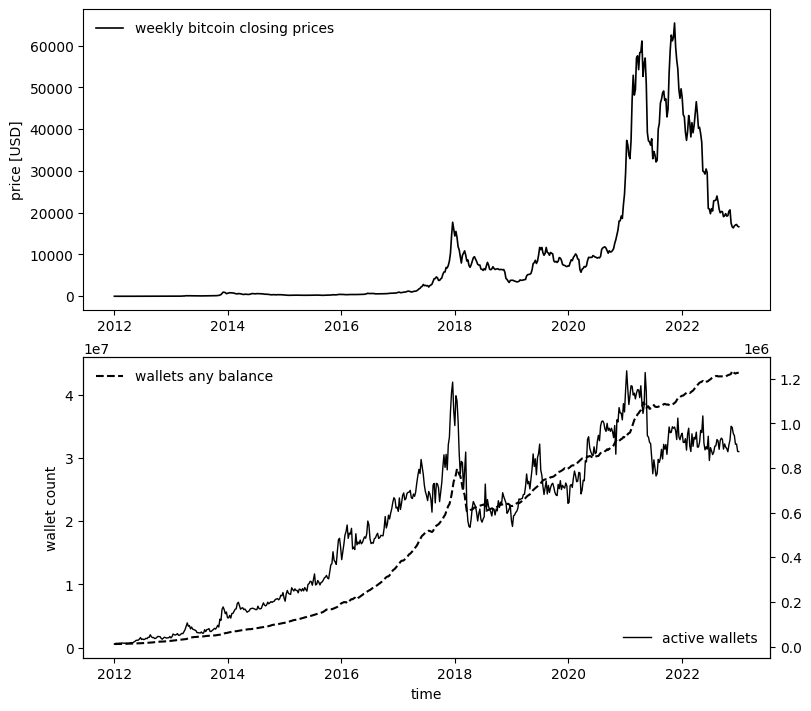

In [24]:
# Create a figure with specified size and constrained layout
fig = plt.figure(figsize=(8, 7), constrained_layout=True)

# Create a grid layout with 2 rows and 2 columns for subplots
gs = GridSpec(2, 2, figure=fig)

# Create the first subplot in the top row
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(wltW.Close, color='black', linewidth=1.2, label='weekly bitcoin closing prices')
ax1.set_ylabel('price [USD]')

# Get legend handles and labels for the first subplot
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc='upper left', frameon=0)

# Create the second subplot in the bottom row
ax2 = fig.add_subplot(gs[1, :])
ax2.plot(wltW.Count, color='black', linewidth=1.5, linestyle='dashed', label='wallets any balance')
ax2.set_ylabel('wallet count')

# Create a twin y-axis for the second subplot
ax22 = ax2.twinx()
ax22.plot(wltW.Active, color='black', linewidth=1, label='active wallets')
ax2.set_xlabel('time')

# Get legend handles and labels for the second subplot
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels, loc='upper left', frameon=0)
handles, labels = ax22.get_legend_handles_labels()
ax22.legend(handles, labels, loc='lower right', frameon=0)

# Uncomment the 'plt.savefig()' statement to export the plot as an SVG image
# plt.savefig(fname="../figures/btc_wallets.svg", format="svg")

plt.show()


**Upper Plot**:
- **Content**: Represents the weekly closing prices of Bitcoin.
- **Visual Elements**: The data from the `Close` column of the `wltW` DataFrame is plotted as a continuous line in black, with a linewidth of 1.2. This line is labeled as "weekly bitcoin closing prices".
- **Y-axis Label**: "price [USD]".  

**Lower Plot**:
- **Content**: Illustrates two metrics:
   1. Count of Bitcoin wallets with any balance over time, derived from the `Count` column of the `wltW` DataFrame.
   2. Count of active Bitcoin wallets, sourced from the `Active` column.
- **Visual Elements**: The wallet count is visualized as a dashed black line with a linewidth of 1.5 and labeled as "wallets any balance". The active wallet count is plotted on a twin y-axis as a continuous black line with a linewidth of 1, labeled "active wallets".
- **Y-axis Label**: "wallet count" for the primary y-axis.  


## BTC Price Data Statistics

In the subsequent code block, we import the Bitcoin price data from a CSV file:

**Reading the Data**: The data is sourced from a CSV file named `bitcoin-prices.csv` located in the `../data/BTC/` directory using the `pandas` library.
**Reordering Rows**: The rows in the `asset` DataFrame are reordered in reverse to ensure that the data is chronologically arranged.  
**Index Reset**: The index of the DataFrame is reset to make it sequential, and the previous index is dropped.  
**Date Conversion**: The 'Date' column in the `asset` DataFrame is converted to a datetime object for easier time series manipulation.  
**Data Inspection**: The imported data's length (in days) is printed out for a quick review, and the DataFrame `asset` is displayed.  

This process ensures that the data is correctly formatted and ready for subsequent analysis.


In [25]:
# Import BTC Price Data
asset = pd.read_csv("../data/BTC/bitcoin-prices.csv")
asset = asset.reindex(index=asset.index[::-1])
asset.reset_index(inplace=True, drop=True)
asset['Date'] =  pd.to_datetime(asset['Date'])

# Show imported data for inspection
print('Data imported ... containing ' + str(len(asset)) + ' observations (rows)')
print('Start: ' + str(asset.index[0]) + ' | End: ' + str(asset.index[-1]))
print('Columns: ' + str(list(asset.columns)))

Data imported ... containing 4581 observations (rows)
Start: 0 | End: 4580
Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']


In the upcoming code segment, we focus on refining the dataset to a specific time frame:
  
**Timeframe Selection**: We are narrowing down the dataset to only include observations from December 31, 2011, to January 1, 2023.  
**Filtering**: Using the `Date` column in the `asset` DataFrame, boolean indexing is employed to filter the rows based on the defined start and stop dates.  
**Data Inspection**: After filtering, the length of the trimmed dataset (in days) is displayed, and the resulting `asset` DataFrame is shown.  

This operation ensures that only the relevant period's data is retained for subsequent analysis.


In [28]:
# Narrow down data to the desired time period
start = asset['Date'] >= pd.to_datetime('2011-12-31')
stop = asset['Date'] < pd.to_datetime('2023-01-01')
asset = asset[start]
asset = asset[stop]

# Show imported data for inspection
print('Data imported ... containing ' + str(len(asset)) + ' observations (rows)')
print('Start: ' + str(asset['Date'].iloc[0]) + ' | End: ' + str(asset['Date'].iloc[-1]))
print('Columns: ' + str(list(asset.columns)))

Data imported ... containing 4019 observations (rows)
Start: 2011-12-31 00:00:00 | End: 2022-12-31 00:00:00
Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']


In the following code block, we undertake several calculations and transformations on the Bitcoin price data:

**Logarithmic Transformations**:
- `logPrice`: Computes the natural logarithm of the 'Close' column, capturing the logarithmic scale of Bitcoin's closing prices.
- `logDiff`: Represents the detrended value of the `logPrice`. Detrending removes potential linear trends from the logPrice series.
- `Returns`: Calculates the difference between consecutive values in the `logDiff` series, representing the log returns.

**Dataframe Refinement**:
- The columns 'Date', 'Close', 'logPrice', 'logDiff', and 'Returns' are extracted into a new DataFrame named `data`.
- Any NaN values are dropped, and the index is reset.
- `normReturns`: Represents the standardized returns by dividing the `Returns` by its standard deviation.
- `normPrice`: Standardizes the `logDiff` values by dividing them by their standard deviation.

**Date Formatting**:
- The 'Date' column for both `asset` and `data` DataFrames is ensured to be in the datetime format for better time series operations.
- The 'Date' column in the `asset` DataFrame is set as its index.

**Logarithmic Fit**:
- A linear regression is performed on the logarithm of the 'Close' prices against the index. This captures the trend in the logarithmic scale of the closing prices.
- The fit is then transformed back to the original scale, and the resulting values are stored in the `logfit` column of the `asset` DataFrame.

Post these transformations, the `data` DataFrame, now enriched with the aforementioned calculated columns, is displayed for inspection. This resulting dataset offers a comprehensive view of Bitcoin's price dynamics in both its original and transformed scales.


In [29]:
# Calculate differences and logarithms
asset['logPrice'] = np.log(asset.Close)
asset['logDiff'] = detrend(asset.logPrice)
asset['Returns'] = asset.logDiff.diff()
data = asset[['Date','Close','logPrice','logDiff','Returns']].dropna().reset_index(drop=True)
data['Date'] =  pd.to_datetime(data['Date'])
data['normReturns']= data['Returns'] / data.Returns.std()
data['normPrice']= data['logDiff'] / data['logDiff'].std()
asset.set_index(pd.to_datetime(asset['Date']), inplace=True)

# calculate logarithmic fit and add as new column
reg = np.polyfit(data.index, np.log(data.Close), deg=1)
exp = np.exp(reg[1]) * np.exp(reg[0]) ** data.index
exp = np.append(exp, [9.69560404e+04], axis=0)
asset['logfit'] = exp

# Show calculated data for inspection
print('Added calculations as new columns ... containing ' + str(len(data)) + ' observations (rows)')
print('Start: ' + str(data['Date'].iloc[0]) + ' | End: ' + str(data['Date'].iloc[-1]))
print('Columns: ' + str(list(data.columns)))

Added calculations as new columns ... containing 4018 observations (rows)
Start: 2012-01-01 00:00:00 | End: 2022-12-31 00:00:00
Columns: ['Date', 'Close', 'logPrice', 'logDiff', 'Returns', 'normReturns', 'normPrice']


In the following code block, a comprehensive visualization is generated, providing insights into Bitcoin's price and wallet dynamics. 
After executing this block, the resulting visualization will provide a multi-faceted view of Bitcoin's price and wallet behavior over the observed period.

**Layout & Configuration**:
   - A figure of size 8x9 inches is created with a constrained layout for optimal spacing.
   - The `GridSpec` function is employed to define a 4x2 grid layout, accommodating the four line plots.

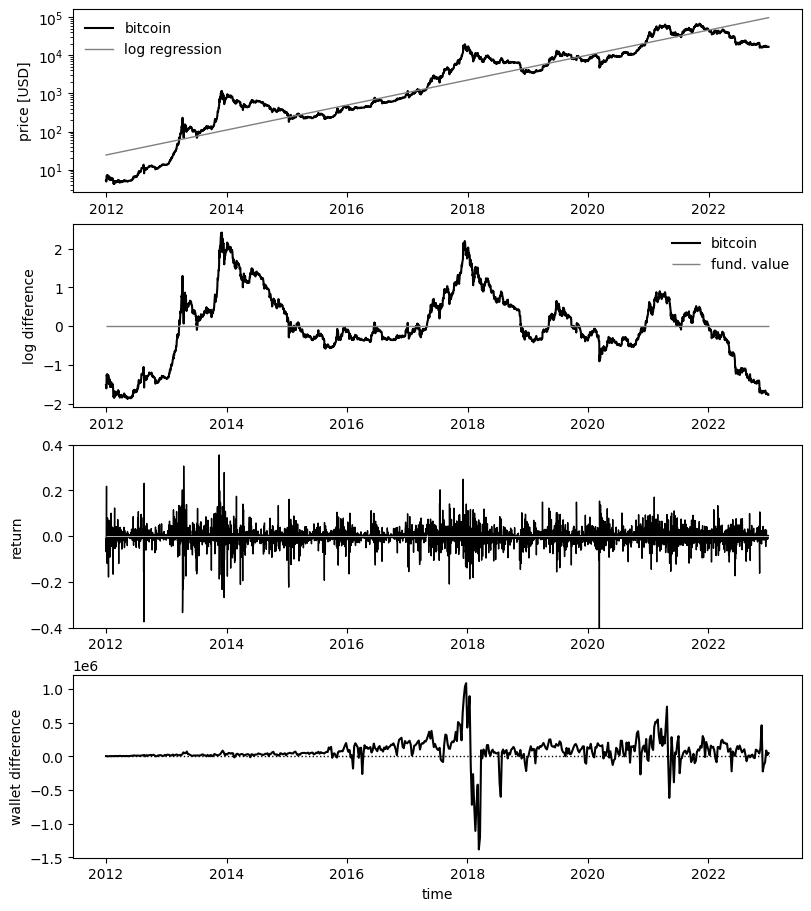

In [16]:
# Create a figure with specified size and constrained layout
fig = plt.figure(figsize=(8, 9), constrained_layout=True)

# Create a grid layout with 4 rows and 2 columns for subplots
gs = GridSpec(4, 2, figure=fig)

# Create the first subplot in the top row
ax0 = fig.add_subplot(gs[0, :])
ax0.plot(asset.Close, color='black', linewidth=1.5, label='bitcoin')
ax0.plot(asset.logfit, color='gray', linewidth=1, label='log regression')
ax0.set_ylabel('price [USD]')
ax0.set_yscale('log')

# Get legend handles and labels for the first subplot
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles, labels, loc='upper left', frameon=0)

# Create the second subplot in the second row
ax1 = fig.add_subplot(gs[1, :])
ax1.plot(asset.logDiff, color='black', linewidth=1.5, label='bitcoin')
ax1.hlines(y=0, xmin=pd.to_datetime('2012-01-01'), xmax=pd.to_datetime('2023-01-01'), linewidth=1, color='grey', label='fund. value')
ax1.set_ylabel('log difference')

# Get legend handles and labels for the second subplot
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc='upper right', frameon=0)

# Create the third subplot in the third row
ax2 = fig.add_subplot(gs[2, :])
ax2.plot(asset.Returns, color='black', linewidth=1)
ax2.hlines(y=0, xmin=pd.to_datetime('2012-01-01'), xmax=pd.to_datetime('2023-01-01'), linewidth=0.5, color='white')
ax2.set_ylim([-.4, .4])
ax2.set_ylabel('return')

# Create the fourth subplot in the fourth row
ax3 = fig.add_subplot(gs[3, :])
ax3.plot(wltW.Wdiff, color='black', linewidth=1.5)
ax3.hlines(y=0, xmin=pd.to_datetime('2012-01-01'), xmax=pd.to_datetime('2023-01-01'), linewidth=1, color='black', linestyle='dotted')
ax3.set_ylabel('wallet difference')
ax3.set_xlabel('time')

# Uncomment the 'plt.savefig()' statement to export the plot as an SVG image
# plt.savefig(fname="../figures/btc_plot.svg", format="svg")


plt.show()


**Top Plot (Bitcoin Prices with Log Regression)**:
   - **Data**: Displays Bitcoin's actual closing prices (`Close`) and a logarithmic regression fit (`logfit`).
   - **Visual Elements**: The closing prices are plotted as a black line with a linewidth of 1.5. The logarithmic regression fit is represented by a gray line.
   - **Y-axis**: Set to a logarithmic scale to better capture the exponential growth and labeled as "price [USD]".

**Second Plot (Logarithmic Price Difference)**:
   - **Data**: Illustrates the detrended logarithmic difference of Bitcoin's prices (`logDiff`).
   - **Visual Elements**: A horizontal line indicating a fundamental value of zero is overlaid on the plot.
   - **Y-axis Label**: "log difference".

**Third Plot (Bitcoin Returns)**:
   - **Data**: Demonstrates the daily returns of Bitcoin (`Returns`).
   - **Visual Elements**: The returns are plotted as a continuous black line. A white horizontal line at zero is added for reference.
   - **Y-axis**: Range is set between -0.4 and 0.4 and labeled as "return".

**Bottom Plot (Wallet Count Difference)**:
   - **Data**: Depicts the differences in the count of Bitcoin wallets over time (`Wdiff`).
   - **Visual Elements**: A dotted black horizontal line at zero is included as a reference.
   - **Y-axis Label**: "wallet difference".
   - **X-axis Label**: "time".


### Autocorrelation and Hill Index

In the upcoming code segment, we execute a series of calculations to gain insights into the statistical properties of Bitcoin's returns:

**Hill Estimator Calculation**:
   - We apply the Hill Estimator to the 'Returns' column to focus on the tail behavior of the return distribution. Specifically, the estimator is applied to the largest 10% of observations.
   - The result is stored in the `tail` variable.

**Hill DataFrame Creation**:
   - The obtained Hill estimations (`tail`) are transformed into a DataFrame named `hill`.
   - The DataFrame is then augmented with a column, `obs_pc`, which represents the percentage of total observations for each entry.

**Autocorrelation Computations**:
   - Autocorrelations of the returns are calculated up to a lag of 100, resulting in the `ac` variable.
   - Additionally, autocorrelations of the absolute returns are computed, yielding the `aac` variable.

**Standard Normal Distribution Calculation**:
   - A standard normal distribution is computed over a range from -3 to 3. This will be useful for subsequent plotting and comparison tasks.

Post these calculations, the `hill` DataFrame, which contains the Hill Estimator values, is displayed for inspection. This dataset provides a detailed look into the tail behavior of Bitcoin's returns.


In [37]:
# calculate Hill estimator for the first 10% of largest observations
t = data['Returns'].to_numpy()
tail =  Hill_pro(t, 10)

# create hill data frame
hill = pd.DataFrame(tail)
hill.rename(columns = {0:'tail'}, inplace = True)
hill['obs_pc'] = hill.index / len(t) * 100

# calculate autocorrelations of returns and create data frames
lag = 100
ac = acf(data.Returns, nlags=lag)
aac = acf(abs(data.Returns), nlags=lag)

# Show calculated data for inspection
print('Hill date frame created ... containing ' + str(len(hill)) + ' observations (rows)')
print('Start: ' + str(list(hill.iloc[0])) + ' | End: ' + str(list(hill.iloc[-1])))
print('Columns: ' + str(list(hill.columns)))
print(' \nAuto-Correlation arrays created ...')
print('AC Start: ' + str(ac[0]) + ' | End: ' + str(ac[-1]))
print('AAC Start: ' + str(aac[0]) + ' | End: ' + str(aac[-1]))

Hill date frame created ... containing 401 observations (rows)
Start: [6.766597778548638, 0.0] | End: [1.9809223360176618, 9.955201592832255]
Columns: ['tail', 'obs_pc']
 
Auto-Correlation arrays created ...
AC Start: 1.0 | End: 0.006999755780878402
AAC Start: 1.0 | End: -0.009218619243430135


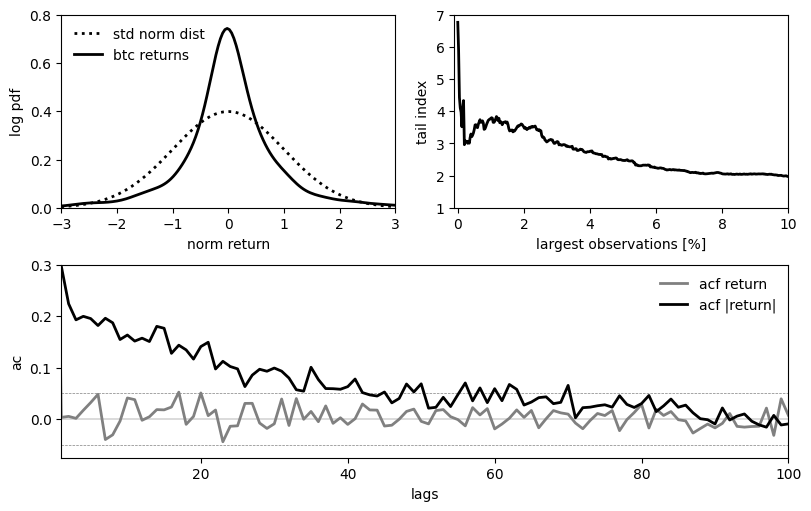

In [17]:
# Create a figure with specified size and constrained layout
fig = plt.figure(figsize=(8, 5), constrained_layout=True)

# Create a grid layout with 2 rows and 2 columns for subplots
gs = GridSpec(2, 2, figure=fig)

# calculate standard normal distribution for usage in plot
x = np.linspace(-3, 3, num=1000)
y = norm.pdf(x, loc=0, scale=1)

# Create the first subplot in the first row, first column
ax5 = fig.add_subplot(gs[0, :1])
x = np.linspace(-3, 3, 1000) 
y = 1/np.sqrt(2*np.pi) * np.exp(-x**2/2)
ax5.plot(x, y, linewidth=2, color='black', linestyle='dotted', label='std norm dist')
data.normReturns.plot.kde(color='black', linewidth=2, label='btc returns')
ax5.set_xlim([-3, 3])
ax5.set_ylim([0, 0.8])
ax5.set_ylabel('log pdf')
ax5.set_xlabel('norm return')

# Get legend handles and labels for the first subplot
handles, labels = ax5.get_legend_handles_labels()
ax5.legend(handles, labels, loc='upper left', frameon=0)

# Create the second subplot in the first row, second column
ax3 = fig.add_subplot(gs[0, 1:2])
ax3.plot(hill['obs_pc'], hill['tail'], color='black', linewidth=2)
ax3.set_xlim([-.1, 10])
ax3.set_ylim([1, 7])
ax3.set_ylabel('tail index')
ax3.set_xlabel('largest observations [%]')

# Create the third subplot in the second row
ax4 = fig.add_subplot(gs[1, :])
ax4.hlines(y=0, xmin=1, xmax=100, linewidth=0.2, color='black')
ax4.hlines(y=0.05, xmin=1, xmax=100, linewidth=0.5, linestyle='dashed', color='grey')
ax4.hlines(y=-0.05, xmin=1, xmax=100, linewidth=0.5, linestyle='dashed', color='grey')
ax4.plot(ac, color='grey', linewidth=2, label='acf return')
ax4.plot(aac, color='black', linewidth=2, label='acf |return|')
ax4.set_xlim([1, lag])
ax4.set_ylim([-.075, .3])
ax4.set_ylabel('ac')
ax4.set_xlabel('lags')

# Get legend handles and labels for the fourth subplot
handles, labels = ax4.get_legend_handles_labels()
ax4.legend(handles, labels, loc='upper right', frameon=0)

# Uncomment the 'plt.savefig()' statement to export the plot as an SVG image
# plt.savefig(fname="../figures/btc_stats.svg", format="svg")

plt.show()

## Empirical Moments
- Distortion _D_

Mean of absolute difference between _log price_ and _log fundamental value_

- Volatility _V_

Average Value of absolute Returns

In [39]:
d = np.mean(abs(data['logDiff']))
D = round(d, 5)

print('Distortion: ' + str(D))

v = np.mean(abs(data['Returns']))
V = round(v, 5)

print('Volatility: ' + str(V)) 

Distortion: 0.66826
Volatility: 0.02693


### Tail Index

In [48]:
t = data['Returns'].to_numpy()
cent = 10

tail =  Hill_pro(t, cent)
hill = pd.DataFrame(tail)
hill.rename(columns = {0:'tail'}, inplace = True)
hill['obs_pc'] = hill.index / len(t) * 100

hill_1 = hill[hill['obs_pc'] >= 1]
hill_2 = hill[hill['obs_pc'] >= 2]
hill_3 = hill[hill['obs_pc'] >= 3]
hill_5 = hill[hill['obs_pc'] >= 5]

h1 = round(hill_1['tail'].iloc[0], 4)
h2 = round(hill_2['tail'].iloc[0], 4)
h3 = round(hill_3['tail'].iloc[0], 4)
h5 = round(hill_5['tail'].iloc[0], 4)
h10 = round(hill['tail'].iloc[-1], 4)

print('Hill Index at 1, 2, 3, 5 and 10% level:')
print(h1,h2,h3,h5,h10)

Hill Index at 1, 2, 3, 5 and 10% level:
3.8002 3.4702 3.0578 2.4692 1.9809


### Collect Modes and Save

In [50]:
BTC_modes = dict(
    Distortion = round(D, 4),
    Volatility = round(V, 4),

    hl_1 = h1,
    hl_2 = h2,
    hl_3 = h3,
    hl_5 = h5,
    hl_10 = h10,

    aac_r1btc = round(aac[1], 4),
    aac_r2btc = round(aac[2], 4),
    aac_r3btc = round(aac[3], 4),
    aac_r6btc = round(aac[6], 4),
    aac_r12btc = round(aac[12], 4),
    aac_r25btc = round(aac[25], 4),
    aac_r50btc = round(aac[50], 4),
    aac_r100btc = round(aac[100], 4)
)
BTC_data = pd.DataFrame(data=BTC_modes, index=[0])

BTC_data


,Distortion,Volatility,hl_1,hl_2,hl_3,hl_5,hl_10,aac_r1btc,aac_r2btc,aac_r3btc,aac_r6btc,aac_r12btc,aac_r25btc,aac_r50btc,aac_r100btc
0,0.6683,0.0269,3.8002,3.4702,3.0578,2.4692,1.9809,0.2976,0.2243,0.1931,0.182,0.1574,0.0977,0.0687,-0.0092


In [ ]:

with open("/Users/jones/Coding/Models/Inflow/modes_btc_2013_23.txt", 'w') as f: 
    for key, value in BTC_modes.items(): 
        f.write('%s:%s\n' % (key, value))

BTC_data